In [1]:
import matplotlib.pyplot as plt

from cmb.configs.experiments import Configs
from cmb.data.jetclass import CouplingData
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Configs('transformer.yaml')
jets = CouplingData(config=config.data, standardize=False)
dynamics = ConditionalFlowMatching(config.dynamics)

config.print()

2024-09-19 01:08:36.867629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 01:08:36.911011: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 01:08:36.911723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 01:08:37.712679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


general:
    workdir: ../../results
    experiment_name: beta_to_tops_ConditionalFlowMatching_ParticleTransformer_2024.09.19_01h08
data:
    dataset: JetClass
    target:
        name: tops
        path: ['/home/df630/CMB/data/JetClass/TTBar_000.root']
    source:
        name: beta
        concentration: [1.0, 10.0]
        path: None
    min_num_particles: 0
    max_num_particles: 128
    dim:
        continuous: 3
        discrete: 0
        context: 0
model:
    name: ParticleTransformer
    num_attention_blocks: 6
    num_heads: 4
    dim:
        hidden: 256
        emb:
            time: 16
            continuous: None
            discrete: None
            context: None
    embedding:
        time: sinusoidal
        continuous: None
        discrete: None
        context: None
    dropout: 0.1
    activation: GELU
train:
    device: cuda:0
    multi_gpu: False
    batch_size: 512
    data_split_frac: [0.8, 0.2, 0.0]
    epochs: 500
    early_stopping: None
    min_epochs: None

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from cmb.models.architectures.utils import (fc_block, 
                                            get_activation_function, 
                                            KANLinear, KAN,
                                            SinusoidalPositionalEncoding,
                                            GaussianFourierFeatures)

class ParticleTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.device = config.train.device
        
        #...hidden dimensions:
        dim_continuous = config.data.dim.continuous
        dim_hidden = config.model.dim.hidden

        #...model params:
        num_attention_blocks = config.model.num_attention_blocks
        num_heads = config.model.num_heads

        self.particle_embedding = ParticleEmbedding(config)
        self.particle_attention_blocks = []
        self.particle_attention_blocks = nn.ModuleList([ParticleAttentionBlock(
                                                        dim_input=dim_hidden, 
                                                        dim_output=dim_hidden, 
                                                        dim_hidden=dim_hidden, 
                                                        num_heads=num_heads, 
                                                        activation=get_activation_function(config.model.activation), 
                                                        dropout=config.model.dropout, 
                                                        attention_embedding='linear') 
                                                        for _ in range(num_attention_blocks)])
        self.projection = nn.Linear(dim_hidden, dim_continuous)
                                                
    def forward(self, t, x, k=None, context=None, mask=None):
        t = t.to(self.device) # time
        x = x.to(self.device) # continuous feature (b, n, dim_continuous) 
        k = k.to(self.device) if k is not None else None  # discrete feature (b, n, dim_discrete)          
        mask = mask.to(self.device)    
        h = self.particle_embedding(t=t, x=x, mask=mask)
        for block in self.particle_attention_blocks:
            h = block(h, mask)
        h = self.projection(h) * mask
        return h

class ParticleEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()

                #...input dimensions:
        dim_continuous = config.data.dim.continuous
        dim_discrete = config.data.dim.discrete
        dim_context = config.data.dim.context

        #...embedding dimensions:
        dim_time_emb = config.model.dim.emb.time
        dim_continuous_emb = config.model.dim.emb.continuous
        dim_discrete_emb = config.model.dim.emb.discrete
        dim_context_emb = config.model.dim.emb.context
        dim_hidden = config.model.dim.hidden
        time_embedding = config.model.embedding.time

        # Define the time embedding based on the provided configuration
        if time_embedding == 'sinusoidal': 
            self.time_embedding = nn.Sequential(
                SinusoidalPositionalEncoding(dim_time_emb, max_period=10000), 
                nn.Linear(dim_time_emb, dim_time_emb)
            )
        elif time_embedding == 'kolmogorov-arnold': 
            self.time_embedding = nn.Sequential(
                KANLinear(1, dim_time_emb), 
                nn.Linear(dim_time_emb, dim_time_emb)
            )
        elif time_embedding is None: 
            self.time_embedding = nn.Identity()
        else: 
            raise NotImplementedError

        # Define the main embedding layer
        self.embedding = nn.Linear(dim_continuous + dim_time_emb, dim_hidden)

    def forward(self, t, x, k=None, mask=None):
        """
        Forward pass of the particle embedding.

        Arguments:
        - t: Time input of shape (batch_size, 1) or (batch_size, 1, 1)
        - x: Particle continuous features of shape (batch_size, max_num_particles, dim_continuous)
        - mask: Binary mask of shape (batch_size, max_num_particles, 1) indicating valid particles (1) or masked particles (0)

        Returns:
        - h: Embedded particles of shape (batch_size, N, dim_hidden), masked appropriately
        """

        t_emb = self.time_embedding(t.squeeze(-1))  # (batch_size, dim_time_emb)
        t_emb = t_emb.unsqueeze(1).repeat(1, x.shape[1], 1)  # Repeat for each particle -> (batch_size, N, dim_time_emb)            
        t_emb *= mask   
        x *= mask   
        h = torch.cat([t_emb, x], dim=-1)  # (batch_size, N, dim_continuous + dim_time_emb)
        h = self.embedding(h)  # (batch_size, N, dim_hidden)
        h *= mask  
        return h
        
class ParticleAttentionBlock(nn.Module):
    def __init__(self, dim_input, dim_output, dim_hidden=128, num_heads=4, activation=nn.GELU(), dropout=0.0, attention_embedding='linear'):
        super().__init__()
        
        self.layernorm_0 = nn.LayerNorm(dim_input)
        self.mha_block = MultiHeadAttention(dim_input, dim_hidden, dim_hidden, num_heads, dropout, attention_embedding=attention_embedding)
        self.layernorm_1 = nn.LayerNorm(dim_hidden)
        self.layernorm_2 = nn.LayerNorm(dim_hidden)
        self.fc_block = nn.Sequential(nn.Linear(dim_hidden, dim_hidden),
                                      activation,
                                      nn.LayerNorm(dim_hidden),
                                      nn.Linear(dim_hidden, dim_output))
    def forward(self, x, mask):
        h = self.layernorm_0(x)
        h = self.mha_block(h, mask=mask)  # Masking in MHA
        h = self.layernorm_1(h)
        h += x
        f = self.layernorm_2(h)
        f = self.fc_block(f)
        f += h
        f *= mask
        return f


class MultiHeadAttention(nn.Module):
    def __init__(self, dim_input, dim_output, dim_hidden=128, num_heads=4, dropout=0.0, attention_embedding='linear'):
        super().__init__()

        assert dim_hidden % num_heads == 0, "hidden dimension must be divisible by number of heads"
        self.dim_head = dim_hidden // num_heads
        self.num_heads = num_heads
        self.dim_hidden = dim_hidden

        self.register_buffer("tril", torch.tril(torch.ones(dim_hidden, dim_hidden)))

        # Key, Query, and Value linear transformations
        if attention_embedding == 'linear':
            self.k = nn.Linear(dim_input, dim_hidden, bias=False)
            self.q = nn.Linear(dim_input, dim_hidden, bias=False)
            self.v = nn.Linear(dim_input, dim_hidden, bias=False)
        elif attention_embedding == 'kolmogorov-arnold':
            self.k = KANLinear(dim_input, dim_hidden)
            self.q = KANLinear(dim_input, dim_hidden)
            self.v = KANLinear(dim_input, dim_hidden)

        self.proj = nn.Linear(dim_hidden, dim_output)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        b, n, dim = x.shape
        K, Q, V = self.k(x), self.q(x), self.v(x)  # Compute Key, Query, and Value

        # Reshape for multi-head attention
        K = K.view(b, n, self.num_heads, self.dim_head).transpose(1, 2)  # (b, num_heads, n, head_dim)
        Q = Q.view(b, n, self.num_heads, self.dim_head).transpose(1, 2)
        V = V.view(b, n, self.num_heads, self.dim_head).transpose(1, 2)

        # Scaled dot-product attention
        QK = (Q @ K.transpose(-2, -1)) * (self.dim_head ** -0.5)  # (b, num_heads, n, n)

        if mask is not None:
            # Expand mask from (b, n, 1) to (b, num_heads, n, n) for broadcasting
            mask = mask.unsqueeze(1).expand(b, self.num_heads, n, n)
            QK = QK.masked_fill(mask == 0, float("-1e9"))  # Mask out invalid positions

        # Apply the causal mask (if applicable)
        QK = QK.masked_fill(self.tril[:n, :n] == 0, float("-inf"))

        # Attention weights
        A = F.softmax(QK, dim=-1)  # (b, num_heads, n, n)
        A = self.dropout(A)

        # Compute context vector
        h = (A @ V).transpose(1, 2).contiguous().view(b, n, self.dim_hidden)
        h = self.proj(h)
        return h




In [3]:
from cmb.models.trainers import CMBTrainer
epic = ParticleTransformer(config)
generative_model = CMBTrainer(config, dynamics, epic, jets)
generative_model.train()

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


number of training parameters: 2382355
start training...


epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [4]:
from cmb.models.pipelines import Pipeline

pipeline = Pipeline(trained_model=generative_model, config=config)
input = CouplingData(config.data)
pipeline.generate_samples(source_continuous=input.source.continuous[:3000], mask=input.source.mask[:3000])

 30 constutuents:

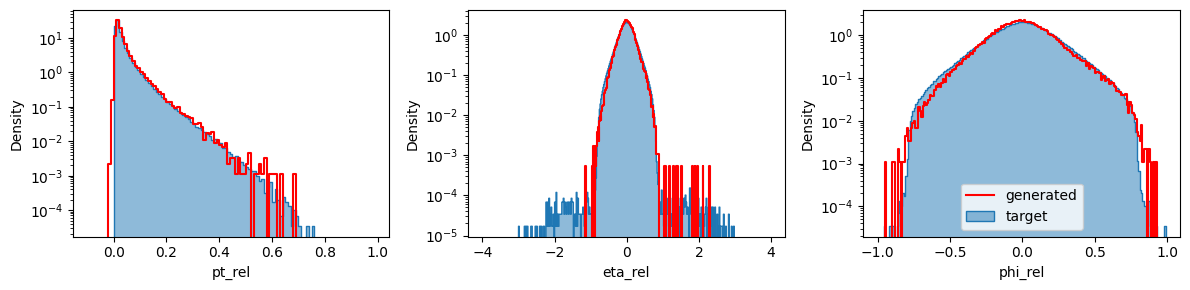

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

x_gen = pipeline.paths[-1].view(-1, 3).detach().cpu().numpy()
fig, ax = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(x_gen[:,0],bins=np.arange(-.1, 1,0.01), ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density', element="step", label='generated')
jets.target.histplot('pt_rel',bins=np.arange(-.1, 1,0.01), ax=ax[0], log_scale=(False, True), stat='density', alpha=0.5, label='target')

sns.histplot(x_gen[:,1], bins=np.arange(-4, 4, 0.02), ax=ax[1], color='r', log_scale=(False, True), fill=False, stat='density', element="step",label='generated')
jets.target.histplot('eta_rel', bins=np.arange(-4, 4, 0.02),ax=ax[1], log_scale=(False, True), stat='density', alpha=0.5, label='target')

sns.histplot(x_gen[:,2], bins=np.arange(-1, 1,0.01), ax=ax[2], color='r', log_scale=(False, True), fill=False, stat='density', element="step",  label='generated')
jets.target.histplot('phi_rel', bins=np.arange(-1, 1,0.01), ax=ax[2], log_scale=(False, True), stat='density', alpha=0.5, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

varying number of constiuents (max.128)

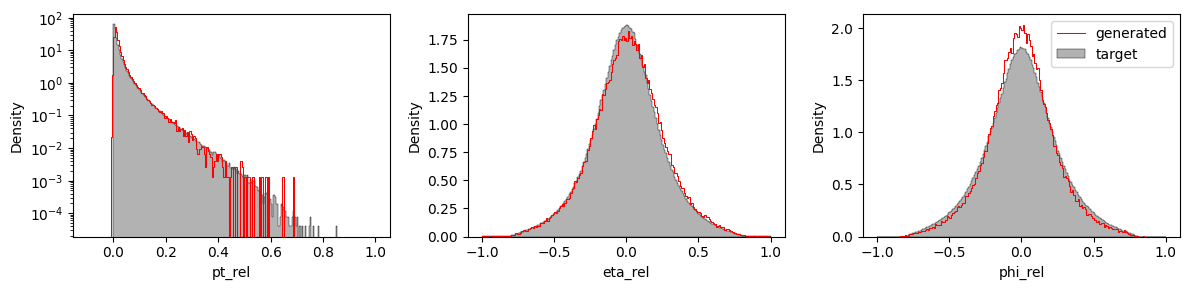

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

x_gen = pipeline.paths[-1][input.source.mask[:3000].squeeze(-1)>0]
x_gen = x_gen.view(-1, 3).detach().cpu().numpy()
fig, ax = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(x_gen[:,0], binrange=(-.1, 1), binwidth=0.005, log_scale=(False, True), fill=False, stat='density', element="step", color='r', lw=0.75, label='generated', ax=ax[0])
jets.target.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, log_scale=(False, True), stat='density', color='k', alpha=0.3, lw=0.3, label='target', ax=ax[0])

sns.histplot(x_gen[:,1], binrange=(-1, 1), binwidth=0.01, color='r', log_scale=(False, True), fill=False, stat='density', element="step", lw=0.75, label='generated', ax=ax[1])
jets.target.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target', ax=ax[1])

sns.histplot(x_gen[:,2], binrange=(-1, 1), binwidth=0.01, ax=ax[2], color='r', fill=False, stat='density', element="step", lw=0.75, label='generated')
jets.target.histplot('phi_rel',binrange=(-1, 1), binwidth=0.01, ax=ax[2],  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()